This example assumes you've read `advanced.py`, and covers:
    - Timeseries binary classification on real data
    - Windowed data format; sequence length 188, 4 windows -> 47 points per window
    - Binary classification visuals
    - Using class weights to handle imbalance

In [1]:
import os
import sys
from pathlib import Path
os.environ['TF_KERAS'] = '1'
os.environ['SCALEFIG'] = '.8'  # scale all drawn plots by 0.8
sys.path.insert(0, str(Path(Path.cwd()).parents[1]))
sys.path.insert(0, os.path.join(Path(Path.cwd()).parents[2], "see-rnn"))

import deeptrain
deeptrain.append_examples_dir_to_sys_path()
from utils import TS_CONFIGS as C
from utils import init_session, make_timeseries_classifier
from see_rnn import features_1D, rnn_histogram, rnn_heatmap

In [2]:
%config InlineBackend.figure_format = 'retina'  # greatly improve display quality

# increase scrollable window height
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

### Dataset info
  - PTB Diagnostic ECG Database - https://www.kaggle.com/shayanfazeli/heartbeat
  - Number of samples: 14552
  - Number of channels: 1
  - Number of classes: 2 (binary classification)
  - Sampling frequency: 125 Hz
  - Datapoints per sequence: 188

### Configure TrainGenerator, DataGenerators, & model

In [3]:
batch_size = 128
window_size = batch_size / 4.    # use 4 windows
assert window_size.is_integer()  # ensure it divides batch_size
window_size = int(window_size)

# Make DataGenerator divide up the (128, 188, 1)-shaped batch
# into 4 slices shaped (128, 47, 1) each, feeding one at a time to model
C['datagen'    ]['preprocessor'] = 'timeseries'
C['val_datagen']['preprocessor'] = 'timeseries'
C['datagen'    ]['preprocessor_configs'] = {'window_size': window_size}
C['val_datagen']['preprocessor_configs'] = {'window_size': window_size}

C['model']['batch_shape'] = (batch_size, window_size, 1)

  - `eval_fn`: need `'predict'` for visuals and custom metrics
  - `key_metric`: `'f1_score'` for imbalanced binary classification
  - `val_metrics`: true positive rate & true negative rate are "class accuracies",
     i.e. class-1 acc & class-2 acc
  - `plot_first_pane_max_vals`: plot only validation loss in first plot window,
    the rest on second, to avoid clutter and keep losses together
  - `class_weights`: "normal" is the minority class; 3x more "abnormal" samples
  - others: see utils.py

In [4]:
C['traingen'].update(dict(
    eval_fn='predict',
    key_metric='f1_score',
    val_metrics=('loss', 'tnr', 'tpr'),
    plot_first_pane_max_vals=1,
    class_weights={0: 3, 1: 1},
    plot_configs=[{'figsize': (8, 5)}],
))
tg = init_session(C, make_timeseries_classifier)

Discovered dataset with matching format
Discovered dataset with matching format
103 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Discovered dataset with matching format
Discovered dataset with matching format
12 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Preloading superbatch ... Discovered dataset with matching format
....................................................................................................... finished, w/ 13184 total samples
Train initial data prepared
Preloading superbatch ... Discovered dataset with matching format
............ finished, w/ 1536 total samples
Val initial data prepared
Logging ON; directory (new): C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logs\M35__model-adam__max.000


### Visualize some samples

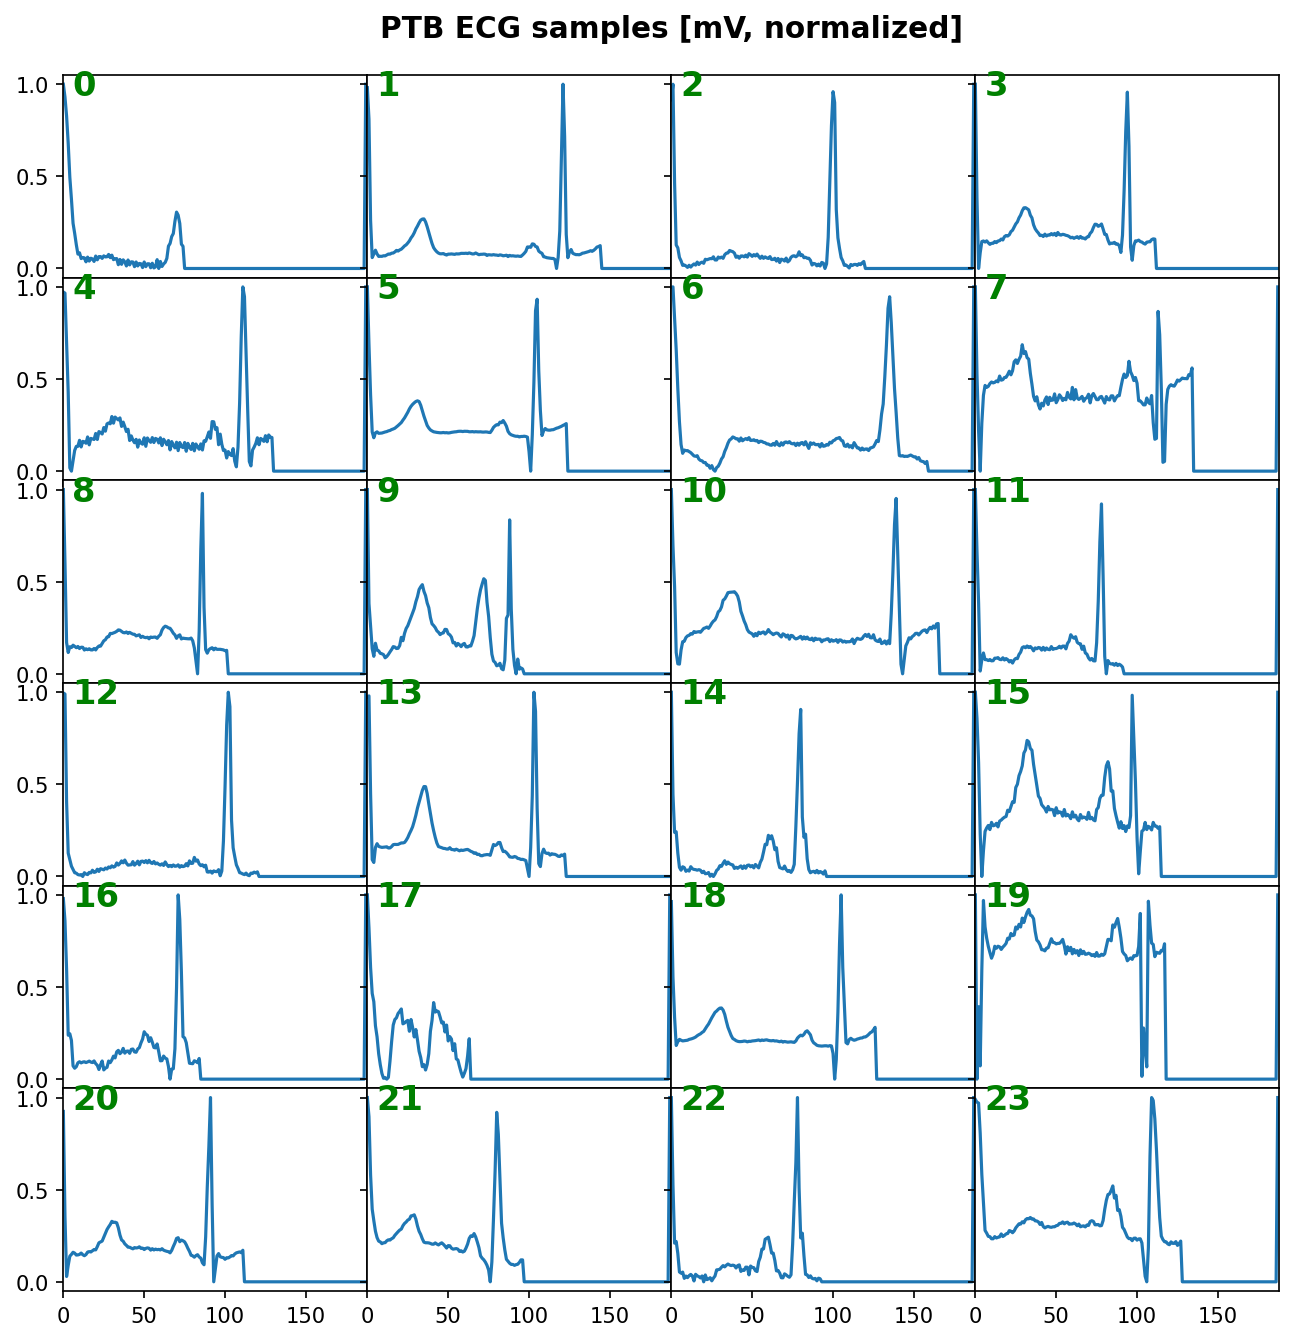

In [5]:
data = tg.val_datagen.batch
_ = features_1D(data[:24], n_rows=6, subplot_samples=True, tight=True,
                title="PTB ECG samples [mV, normalized]")

### Visualize LSTM weights before training

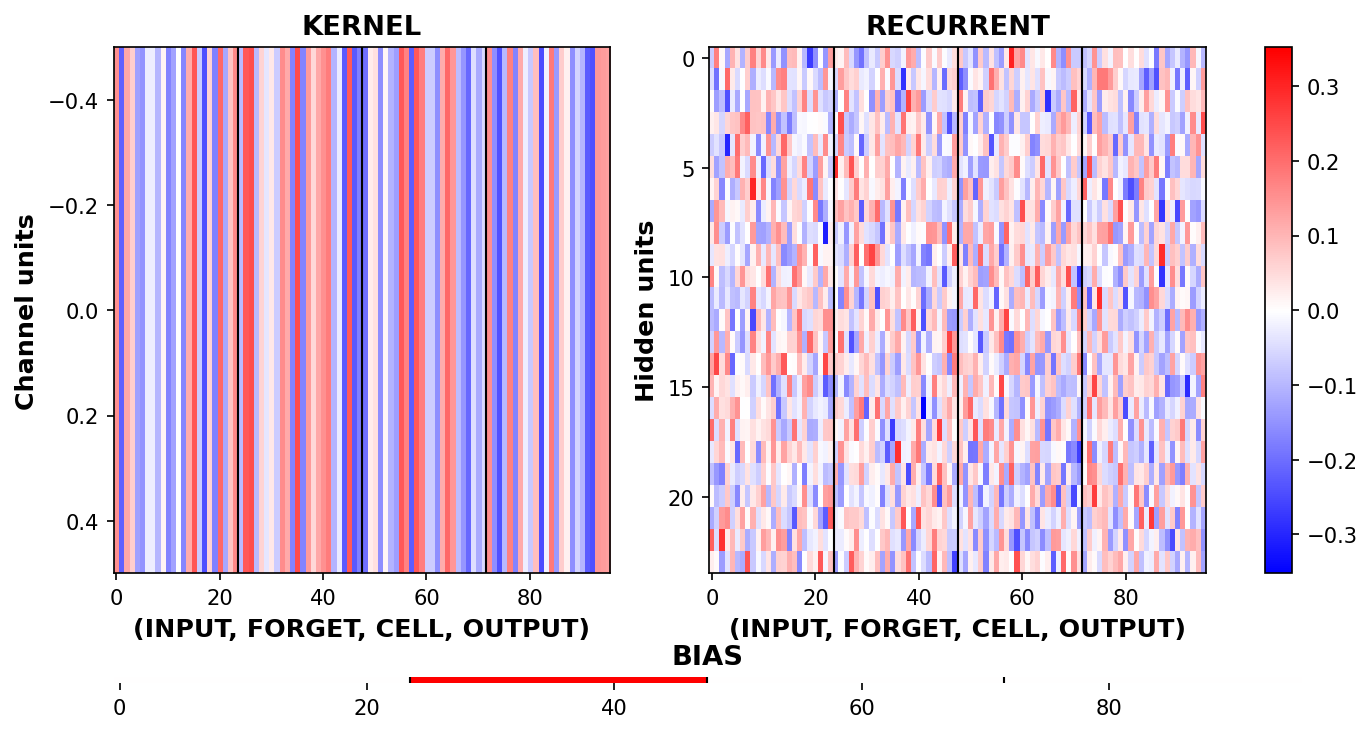

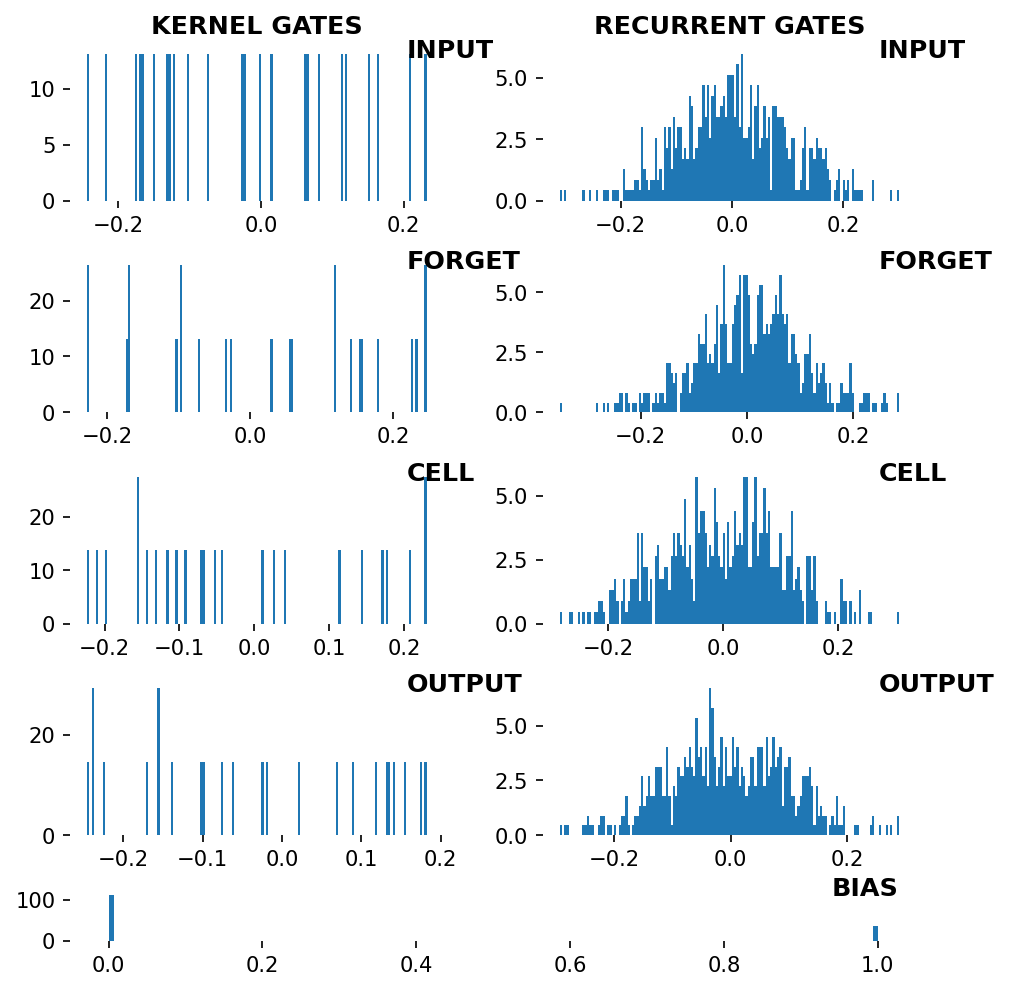

In [6]:
_ = rnn_heatmap(  tg.model, 1, w=.9, h=.9)  # 1 == layer index
_ = rnn_histogram(tg.model, 1, w=.9, h=.9)

### Train


Fitting set 0...   Loss = 1.153130 RNNs reset 
Fitting set 1...   Loss = 1.099359 RNNs reset 
Fitting set 10...  Loss = 1.083649 RNNs reset 
Fitting set 100... Loss = 1.057110 RNNs reset 
Fitting set 101... Loss = 1.043524 RNNs reset 
Fitting set 102... Loss = 1.035275 RNNs reset 
Fitting set 11...  Loss = 1.049327 RNNs reset 
Fitting set 12...  Loss = 1.052469 RNNs reset 
Fitting set 13...  Loss = 1.065604 RNNs reset 
Fitting set 14...  Loss = 1.076242 RNNs reset 
Fitting set 15...  Loss = 1.072925 RNNs reset 
Fitting set 16...  Loss = 1.080710 RNNs reset 
Fitting set 17...  Loss = 1.079061 RNNs reset 
Fitting set 18...  Loss = 1.077707 RNNs reset 
Fitting set 19...  Loss = 1.078878 RNNs reset 
Fitting set 2...   Loss = 1.080019 RNNs reset 
Fitting set 20...  Loss = 1.080318 RNNs reset 
Fitting set 21...  Loss = 1.081976 RNNs reset 
Fitting set 22...  Loss = 1.077959 RNNs reset 
Fitting set 23...  Loss = 1.078474 RNNs reset 
Fitting set 24...  Loss = 1.073548 RNNs reset 
Fitting set 

C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\deeptrain\visuals.py:556: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  ax.set_xlim(xmin, xmax)


Model report generated and saved
Best model saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\models\M35__model-adam__max.422
TrainGenerator state saved
Model report generated and saved


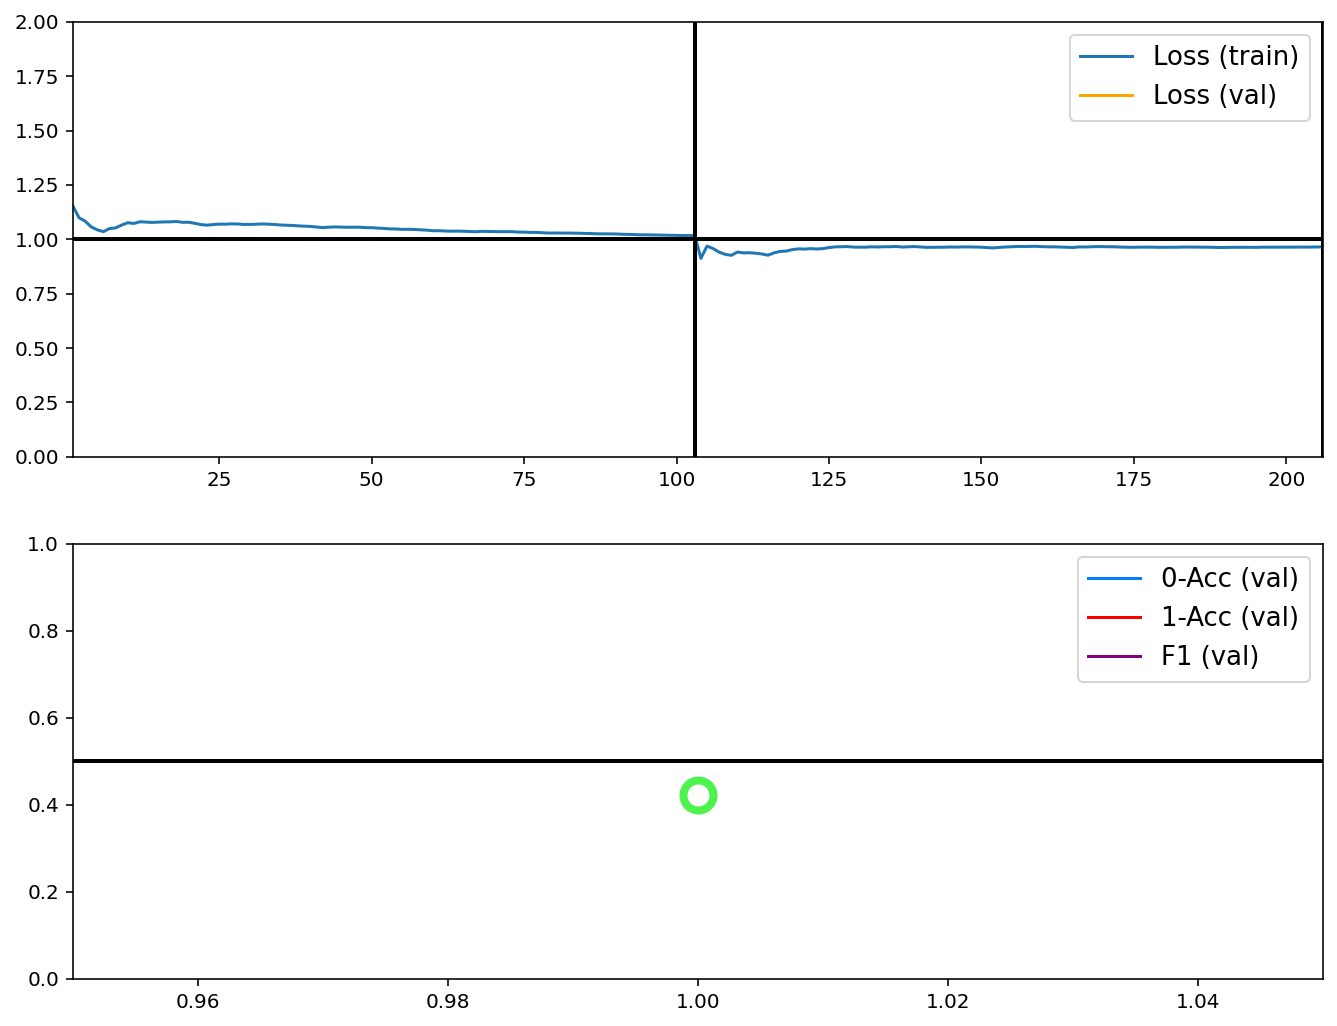

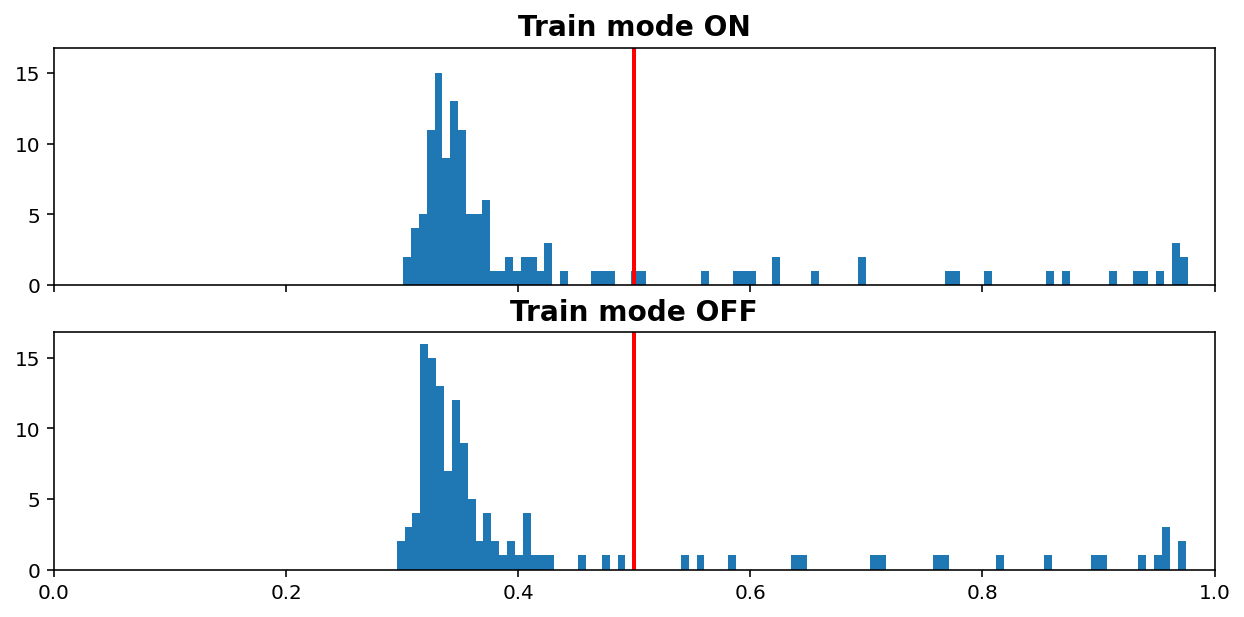

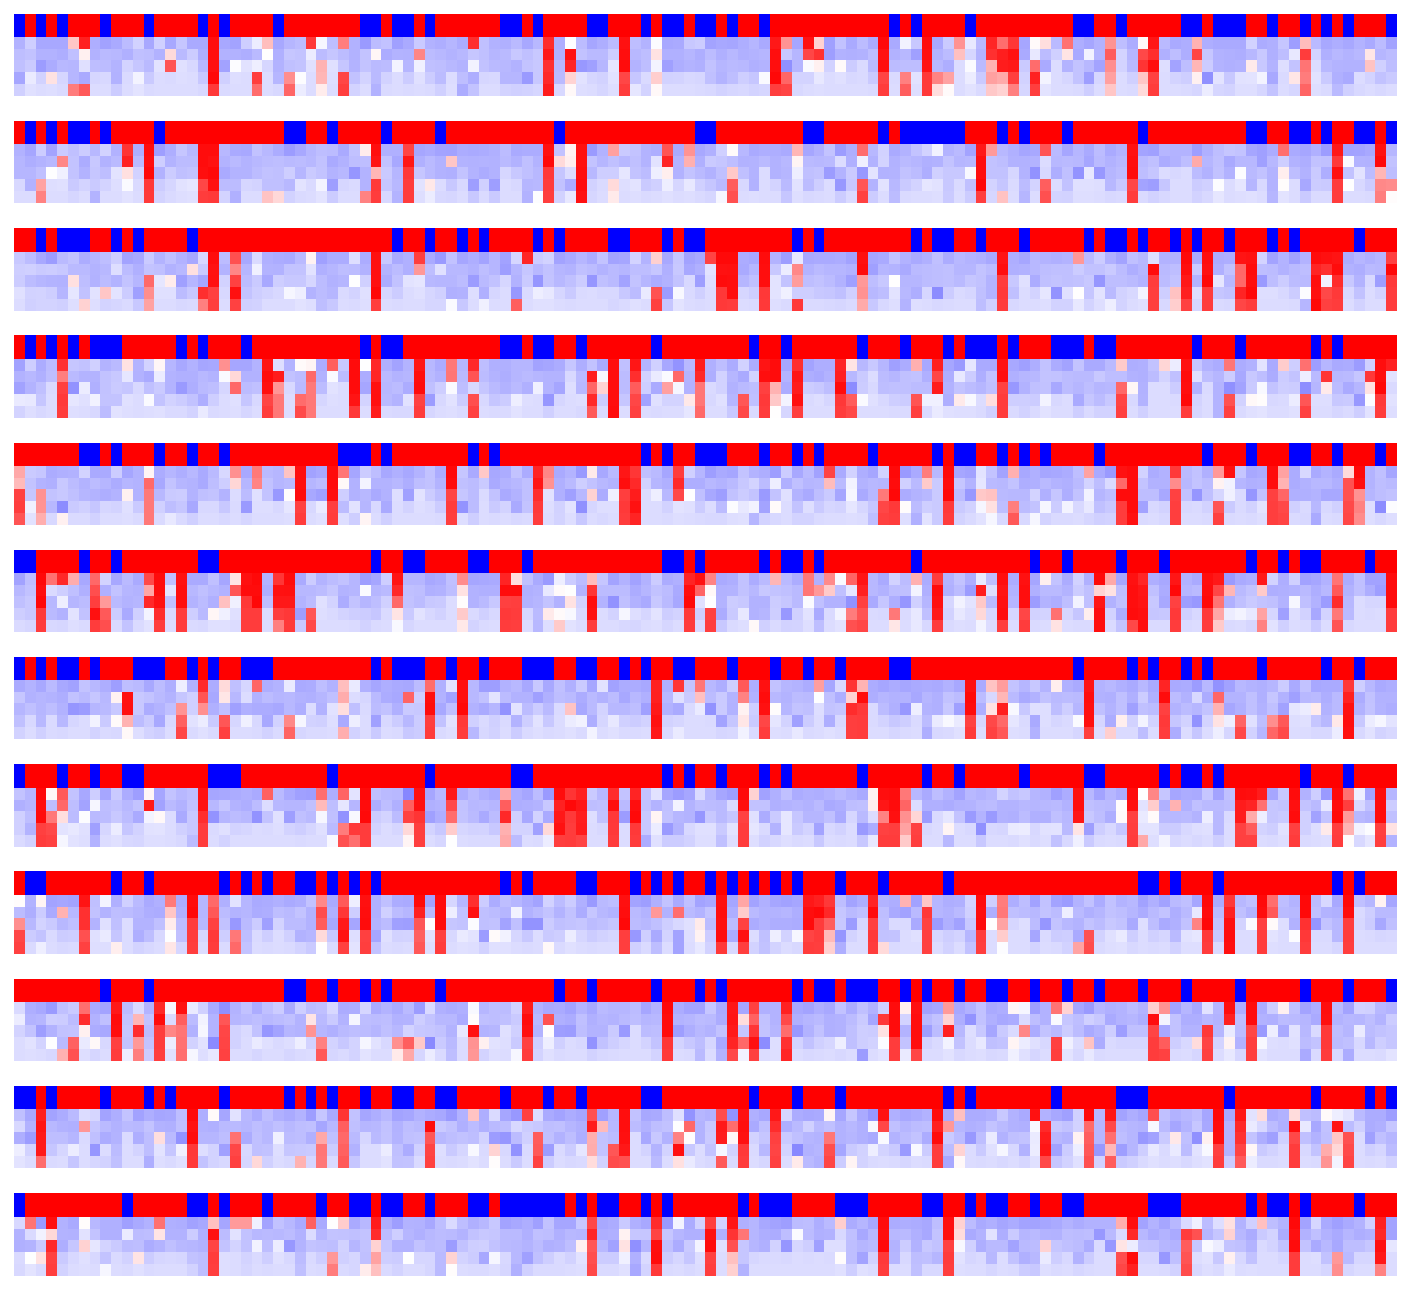

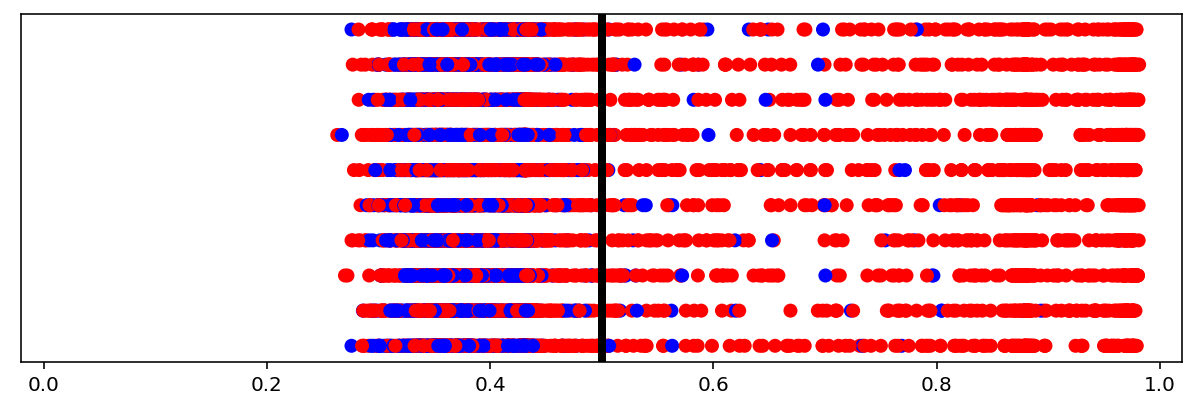


Fitting set 98...  Loss = 1.005704 RNNs reset 
Fitting set 24...  Loss = 0.957658 RNNs reset 
Fitting set 83...  Loss = 0.929028 RNNs reset 
Fitting set 30...  Loss = 0.924628 RNNs reset 
Fitting set 12...  Loss = 0.932295 RNNs reset 
Fitting set 56...  Loss = 0.945487 RNNs reset 
Fitting set 90...  Loss = 0.938974 RNNs reset 
Fitting set 11...  Loss = 0.945624 RNNs reset 
Fitting set 16...  Loss = 0.948657 RNNs reset 
Fitting set 35...  Loss = 0.942165 RNNs reset 
Fitting set 73...  Loss = 0.953518 RNNs reset 
Fitting set 62...  Loss = 0.949875 RNNs reset 
Fitting set 32...  Loss = 0.951699 RNNs reset 
Fitting set 31...  Loss = 0.948998 RNNs reset 
Fitting set 21...  Loss = 0.953427 RNNs reset 
Fitting set 57...  Loss = 0.952727 RNNs reset 
Fitting set 50...  Loss = 0.955215 RNNs reset 
Fitting set 101... Loss = 0.951360 RNNs reset 
Fitting set 68...  Loss = 0.948609 RNNs reset 
Fitting set 85...  Loss = 0.951757 RNNs reset 
Fitting set 27...  Loss = 0.951493 RNNs reset 
Fitting set 

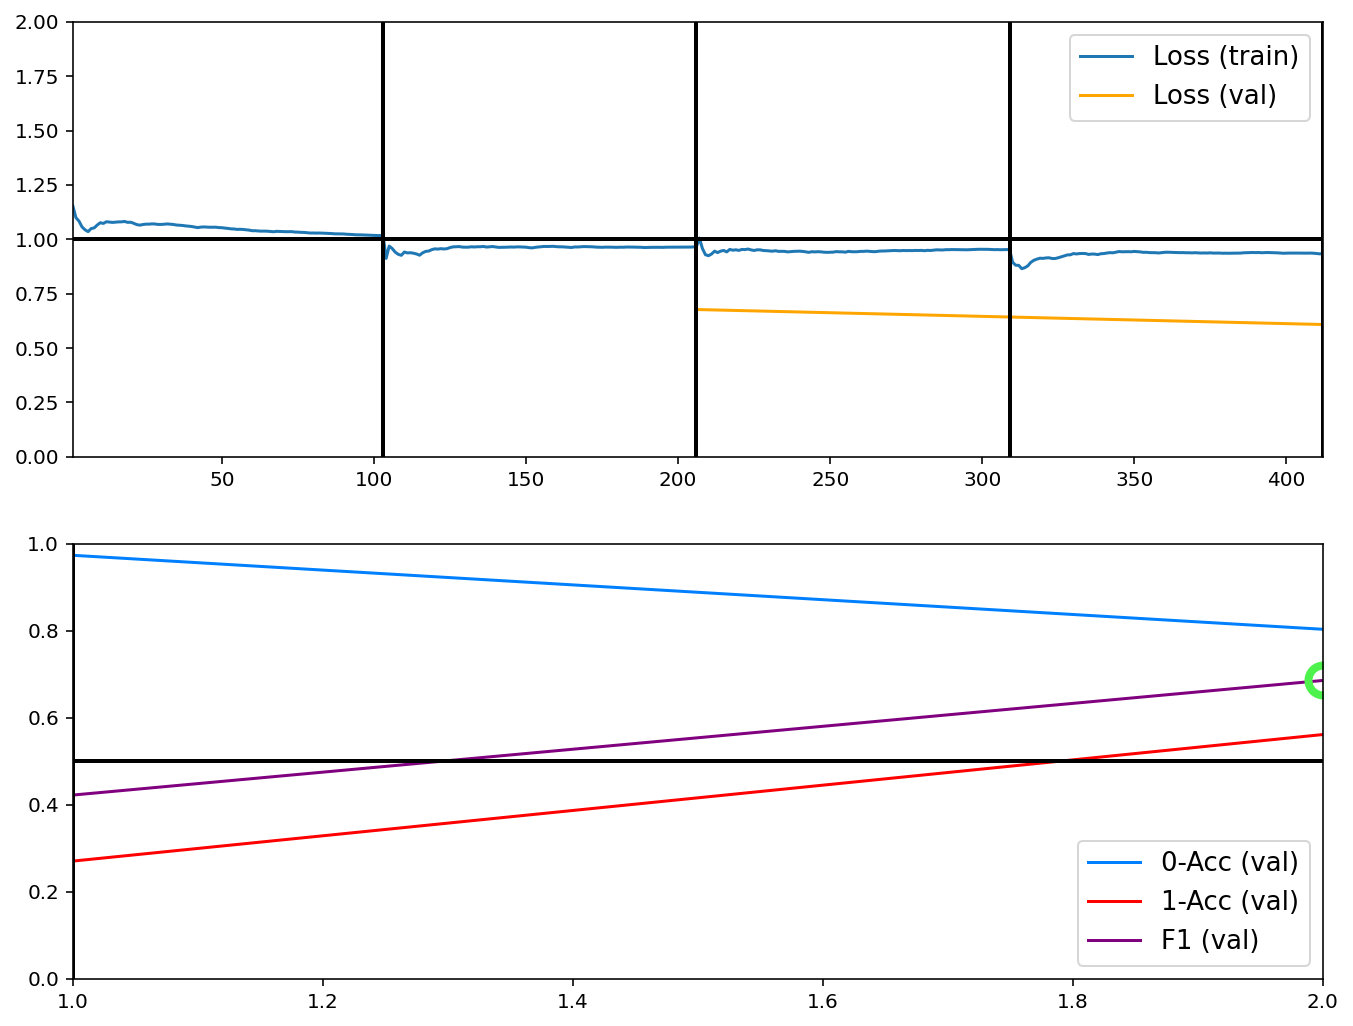

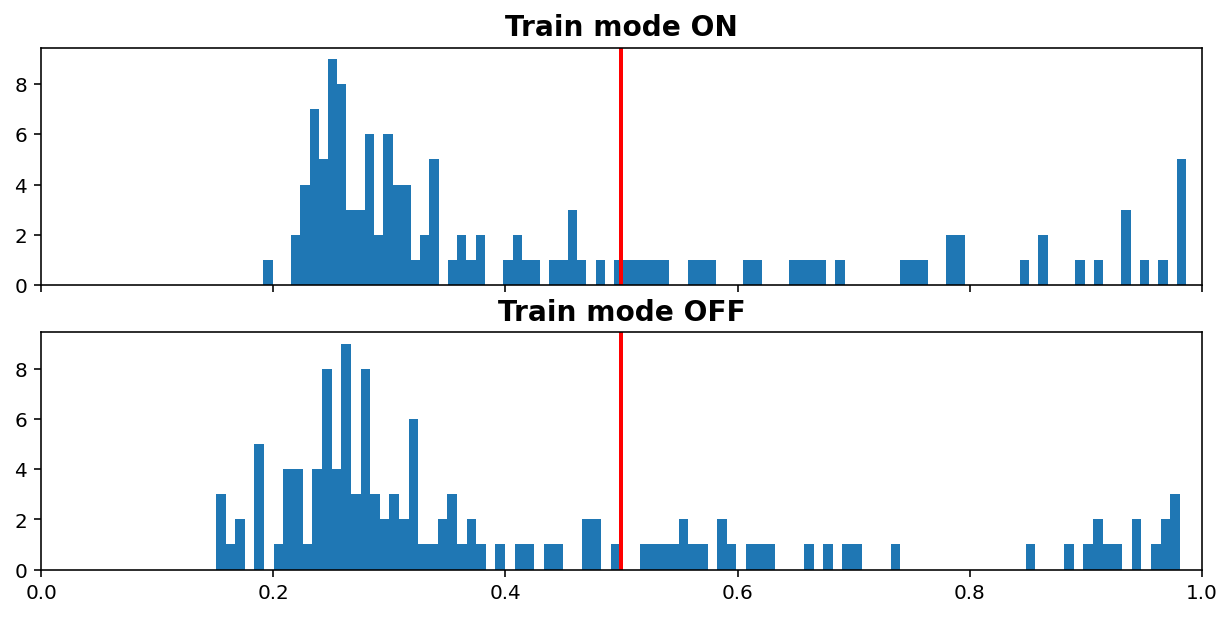

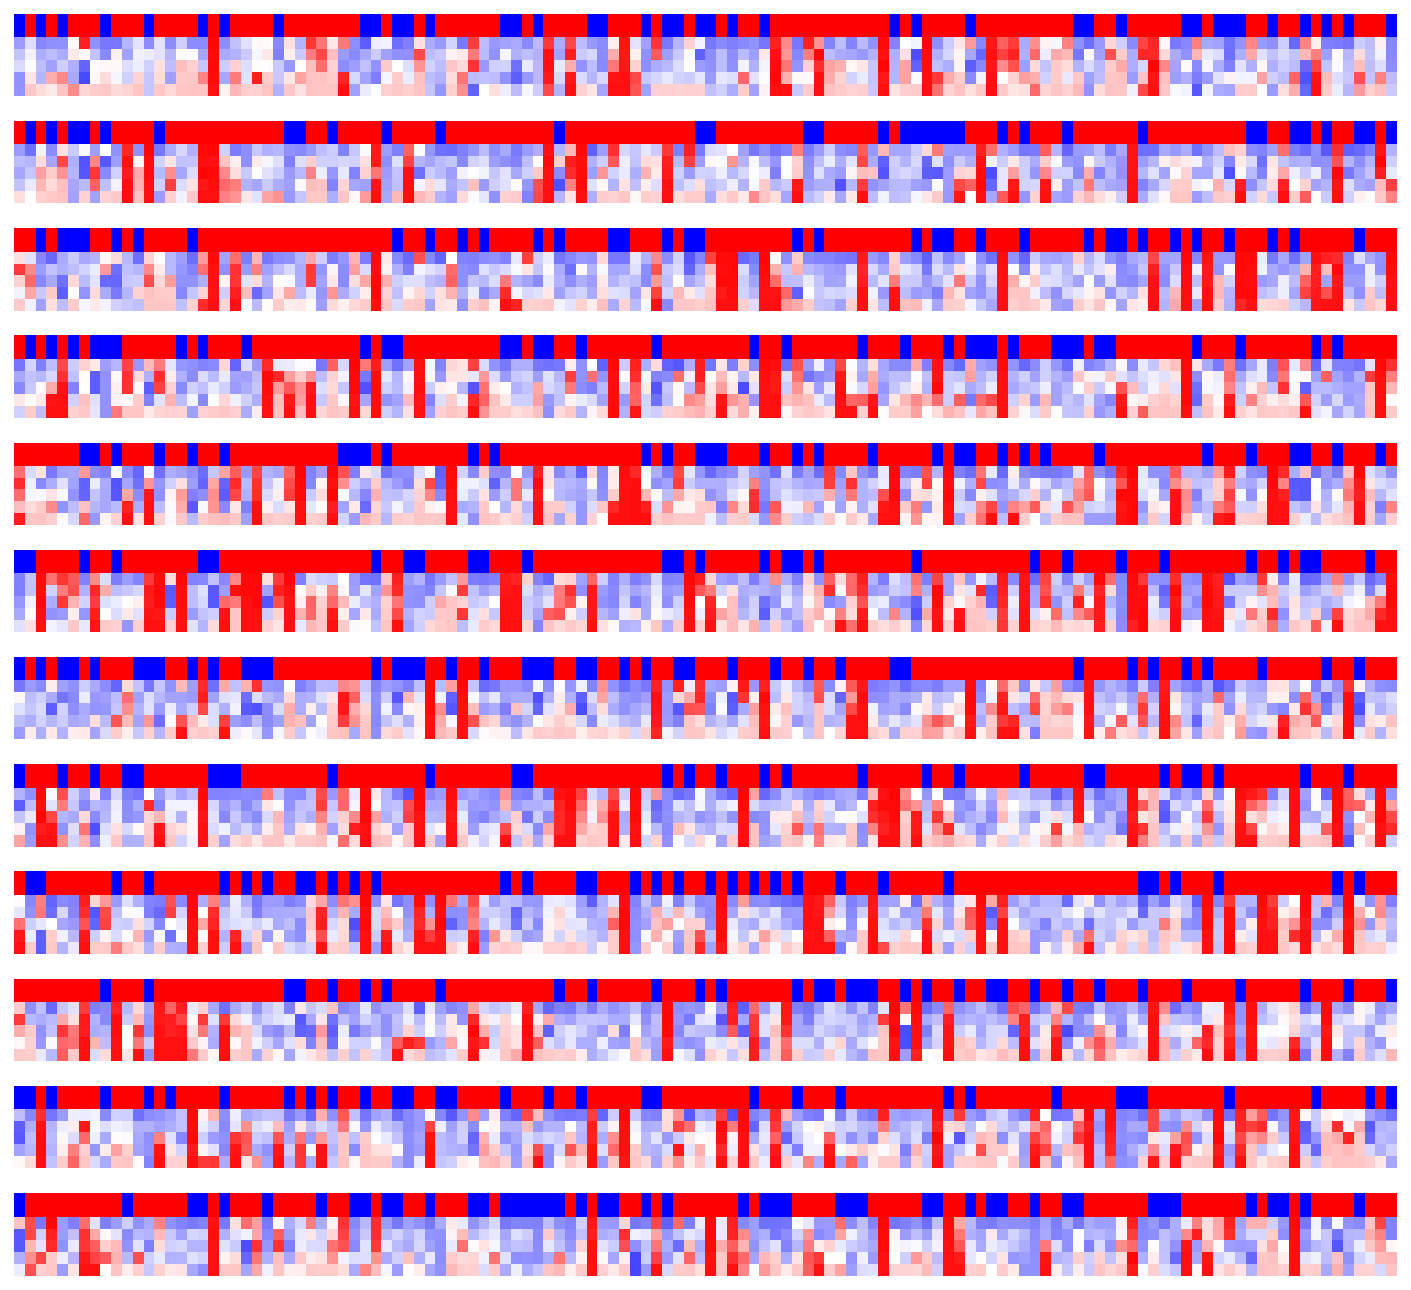

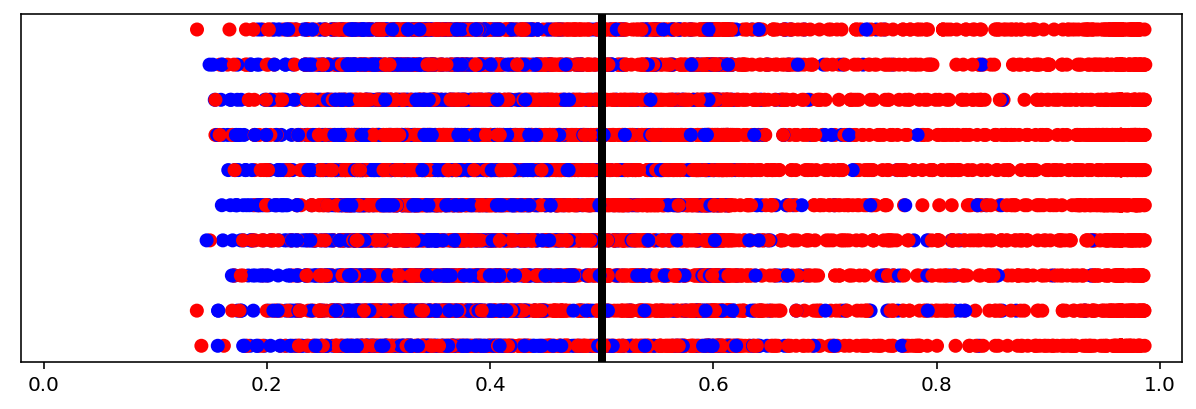

Training has concluded.


In [7]:
tg.train()

### Visualize LSTM weights post-training

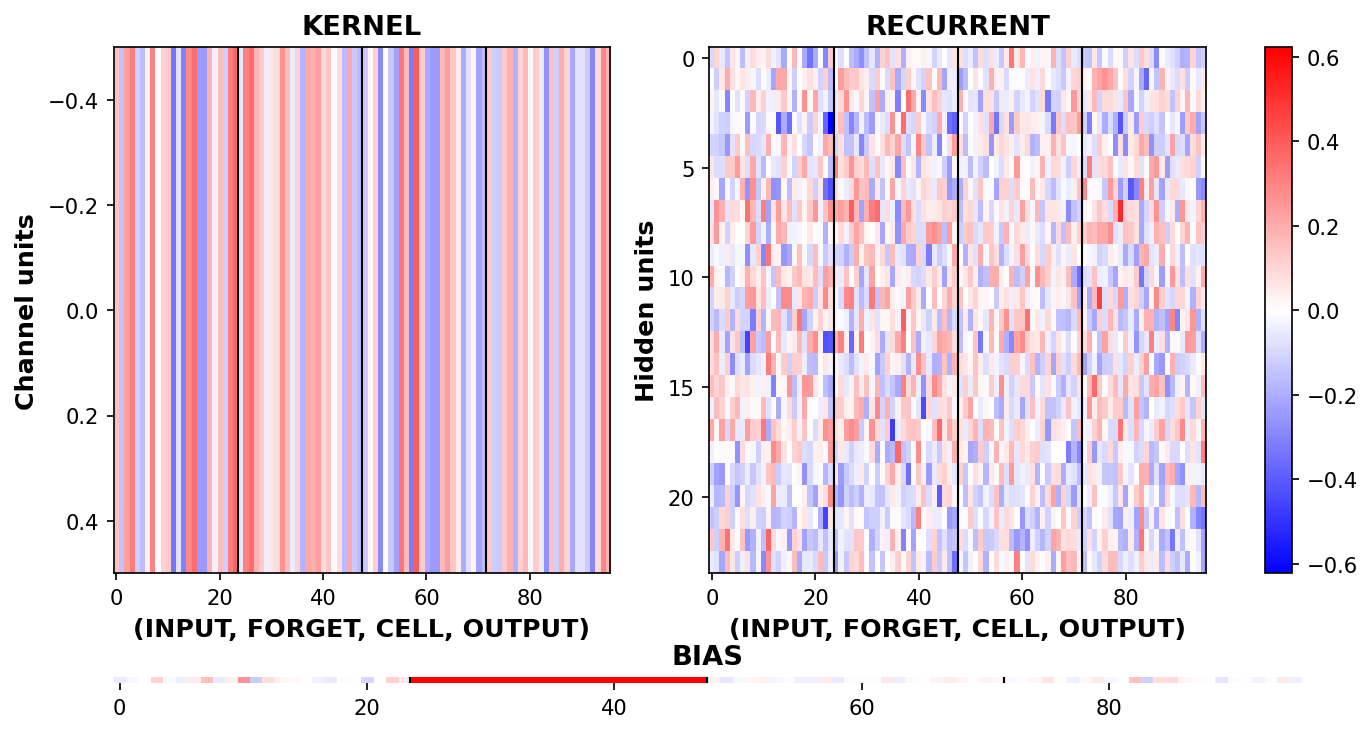

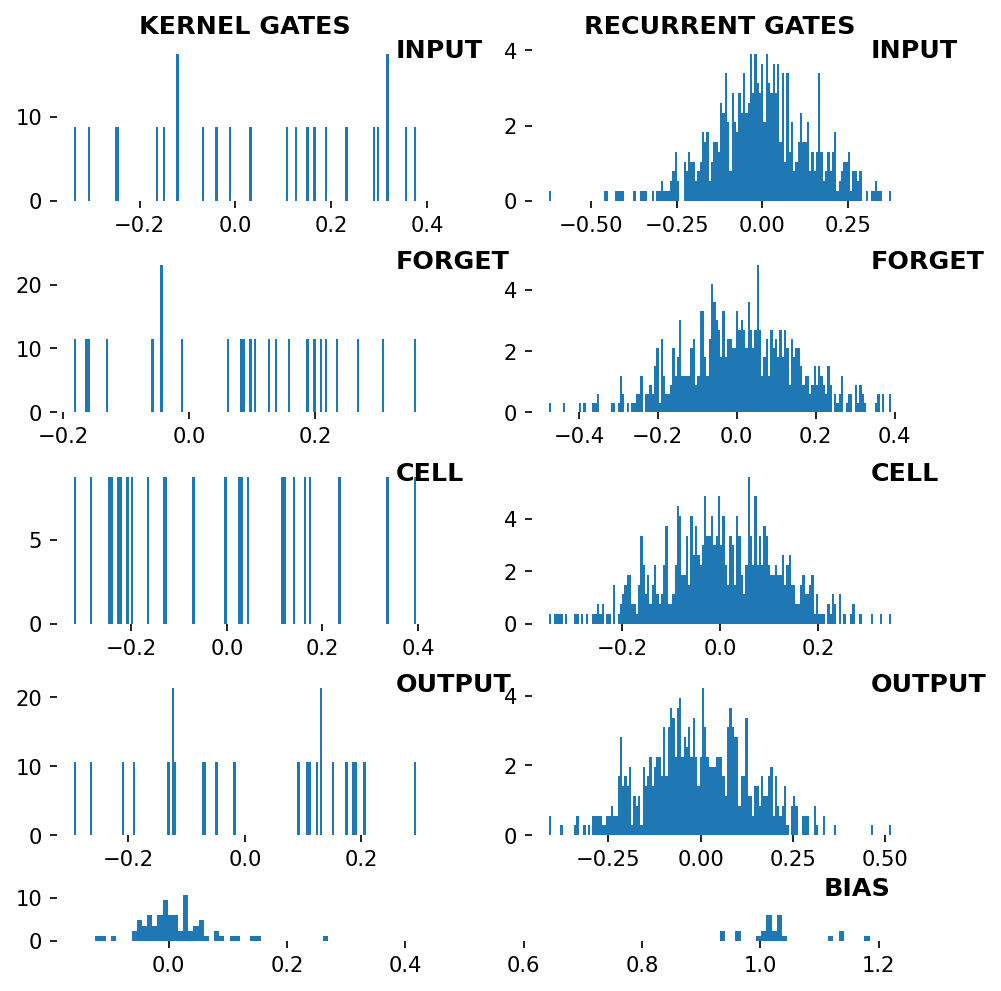

In [8]:
_ = rnn_heatmap(  tg.model, 1, w=.9, h=.9)  # 1 == layer index
_ = rnn_histogram(tg.model, 1, w=.9, h=.9)

Differences are more pronounced when trained longer.

Next we inspect the callback figures; to redraw them, first we re-validate without clearing cache, to then
get predictions & labels from cache for plotting.

In [9]:
tg.validate(clear_cache=False, record_progress=False, use_callbacks=False)



Validating...
Validating set 0...  (Loss, 0-Acc, 1-Acc, F1) = (0.672263, 0.795122, 0.512644, 0.637143) 
RNNs reset Validating set 1...  (Loss, 0-Acc, 1-Acc, F1) = (0.654302, 0.840000, 0.486022, 0.628651) 
RNNs reset Validating set 10... (Loss, 0-Acc, 1-Acc, F1) = (0.625472, 0.828571, 0.503226, 0.641975) 
RNNs reset Validating set 11... (Loss, 0-Acc, 1-Acc, F1) = (0.602403, 0.761111, 0.617391, 0.721728) 
RNNs reset Validating set 2...  (Loss, 0-Acc, 1-Acc, F1) = (0.603798, 0.782353, 0.578723, 0.698331) 
RNNs reset Validating set 3...  (Loss, 0-Acc, 1-Acc, F1) = (0.561549, 0.793103, 0.630303, 0.745520) 
RNNs reset Validating set 4...  (Loss, 0-Acc, 1-Acc, F1) = (0.625359, 0.771429, 0.548837, 0.661064) 
RNNs reset Validating set 5...  (Loss, 0-Acc, 1-Acc, F1) = (0.595562, 0.827586, 0.575758, 0.708075) 
RNNs reset Validating set 6...  (Loss, 0-Acc, 1-Acc, F1) = (0.616082, 0.781818, 0.553684, 0.679587) 
RNNs reset Validating set 7...  (Loss, 0-Acc, 1-Acc, F1) = (0.616048, 0.818182, 0.5284

### Predictions per iteration

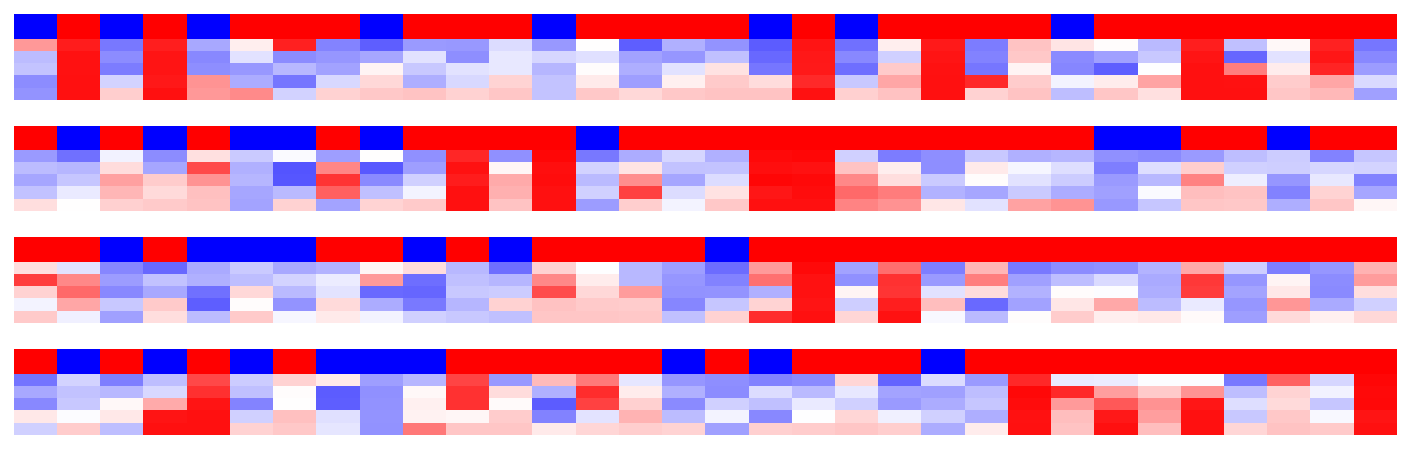

In [25]:
from deeptrain import visuals

lc = np.asarray(tg._labels_cache)
pc = np.asarray(tg._preds_cache)
# select subset for clearer visual
visuals.binary_preds_per_iteration(lc[:4, :, :32], pc[:4, :, :32], h=.9)

 - Four "sets" for four batches
 - For each set, columns = samples (32)
 - Top of each set are labels, plotted with twice the thickness for clarity
 - Below the labels are the predictions, heatmapped between blue (0) and red (1)
 - Each row of predictions is a timeseries window ("slice")
 
Since the model is stateful, if predictions generaly color corretly toward bottom (later windows), it's indicative of LSTMs utilizing past windows. Here we see no such pattern, but training and tuning were limited.

### Predictions distribution

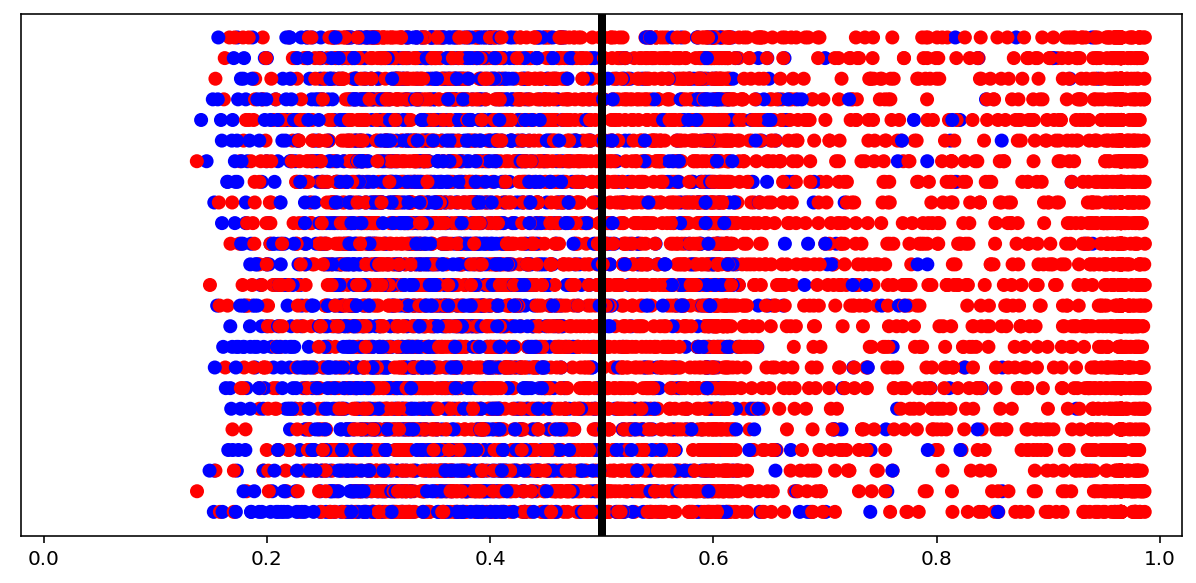

In [43]:
visuals.binary_preds_distribution(lc, pc, pred_th=tg.predict_threshold)

 - Dots = predictions
 - Red  dot at 0.2 = predicted 0.2 for label 1 (red, right of the line = correct)
 - Blue dot at 0.2 = predicted 0.2 for label 0 (blue, left of the line = correct)
 - Vertical line = prediction threshold
 - y-axis is meaningless, vertical space used only to avoid clutter
 
We see more red dots, as expected (0 is minority), and model being biased toward majority class. A better model will have less red on the left, and less blue on the right.<br>
The plot is a good indicator of model "calibration"; sometimes most dots will be either all the way left or all the way right, which may be undesired.

### Inference vs. Train histogram

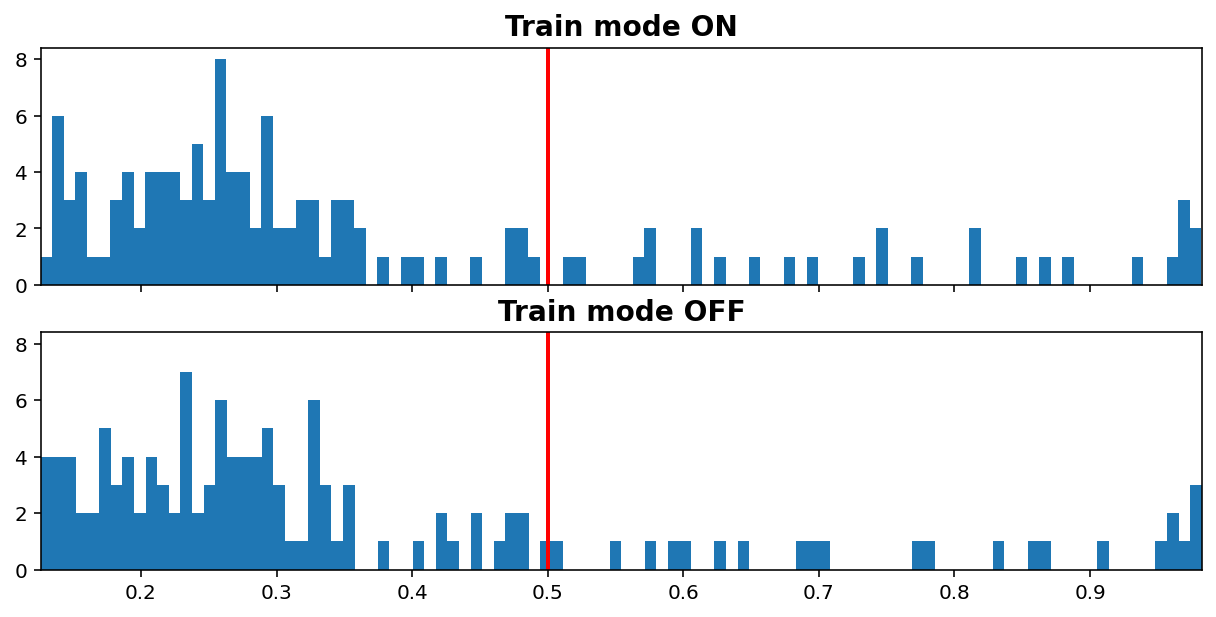

In [45]:
visuals.infer_train_hist(tg.model, tg.val_datagen.get(skip_validation=True)[0],
                         vline=tg.predict_threshold)

 - "Train mode" refers to the `learning_phase` flag
 - When OFF, Dropout rate is 0, Batch Normalization uses moving average instead of batch statistics, and so on

Increasing dropout rate will make ON vs OFF differences more dramatic. Note that the results are only for one validation window; using all would be expensive as we need to compute twice (train & inference), but is doable (see `introspection.py`).